In [1]:
# Import Libraries
# =========================================================

import numpy as np
import pandas as pd
import itertools, warnings

import matplotlib.pyplot as plt
import seaborn as sns

## GLOBAL SETTINGS
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None 
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use("ggplot")
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option("display.max_rows", 500)
plt.rcParams["savefig.bbox"] = "tight"

### BEST CUSTOMERS (manual assessment)

init plan:
1. check customers that brought in the most revenue, assuming each active product per month returns a monthly profit. 
2. categorize customers into none, low, mid, high, premium
3. check retention and churn rates per product per revenue class
4. filter for highest retention, lowest churn and highest revenue class
5. see if it's required to add more dimensions (age, region etc)

In [2]:
df = pd.read_csv("../data/Bobs_df_semi_clean.csv")
df.drop("Unnamed: 0", axis = 1, inplace = True)
df["pk_partition"] = pd.to_datetime(df["pk_partition"])
df["entry_date"] = pd.to_datetime(df["entry_date"])
df["pk_cid"] = df["pk_cid"].astype(str)

In [3]:
df.rename(columns = {
    "payroll": "payroll_product", 
    "payroll_account": "payroll_bonus",
    "active_customer": "active_on_app"}, inplace = True)

In [4]:
product_revenue_map = {"short_term_deposit": 60, "loans": 40, "mortgage": 40, "funds": 60, "securities": 60, "long_term_deposit": 60, "credit_card": 40, "pension_plan": 60, "payroll_product": 10, "emc_account": 10, "debit_card": 40, "em_account_p": 10, "em_acount": 10}
products = list(product_revenue_map.keys())

df_product = df[products]
revenues = np.array([product_revenue_map[f] for f in products])
df['total_revenue'] = (df_product * revenues).sum(axis=1)
df_user_revenue = df.groupby('pk_cid')['total_revenue'].sum().reset_index()
df = pd.merge(df, df_user_revenue, on='pk_cid', how='left')

df.rename(columns = {"total_revenue_x": "revenue_month", "total_revenue_y": "revenue_total"}, inplace = True)

In [5]:
df.rename(columns = {"total_revenue_x": "revenue_month", "total_revenue_y": "revenue_total"}, inplace = True)

<AxesSubplot:ylabel='Frequency'>

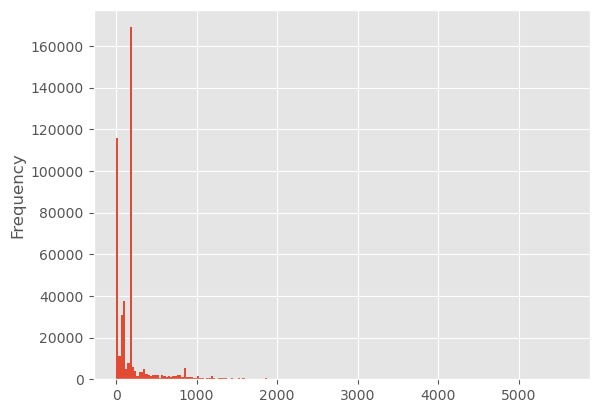

In [6]:
df.groupby("pk_cid")["revenue_total"].min().plot(kind = "hist", bins = 200)

In [7]:
revenue_classes_dict = {
    "None": (-1, 0),
    "Micro": (1, 50),
    "Low": (51, 169),    
    "170": (170, 170.1),    
    "mid": (171, 849),
    "850": (850, 850.1),
    "upper": (851, 1200),
    "high": (1201, 2000),
    "VIP": (2001, 10000)}

df["revenue_class"] = df["revenue_total"].apply(
    lambda x: next(
    (cat for cat, range in revenue_classes_dict.items() if range[0] <= x <= range[1])))

revenue_class
170      166924
None     106347
Low       80585
mid       54902
Micro     20668
upper      9917
high       9410
850        4566
VIP        3054
Name: pk_cid, dtype: int64


<AxesSubplot:xlabel='revenue_class'>

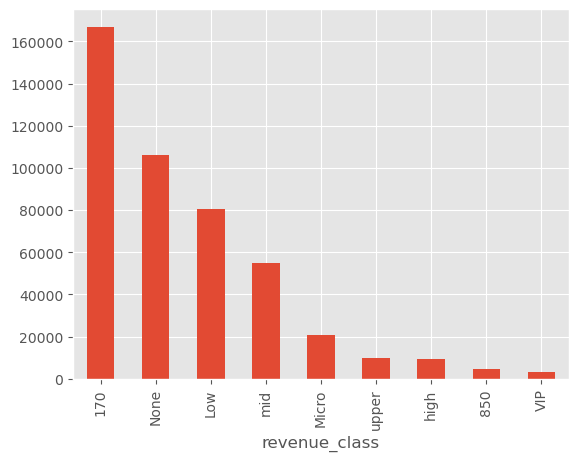

In [8]:
revenue_class_summary = df.groupby("revenue_class")["pk_cid"].nunique().sort_values(ascending = False)
print(revenue_class_summary)
revenue_class_summary.plot(kind = "bar")

<AxesSubplot:xlabel='revenue_class'>

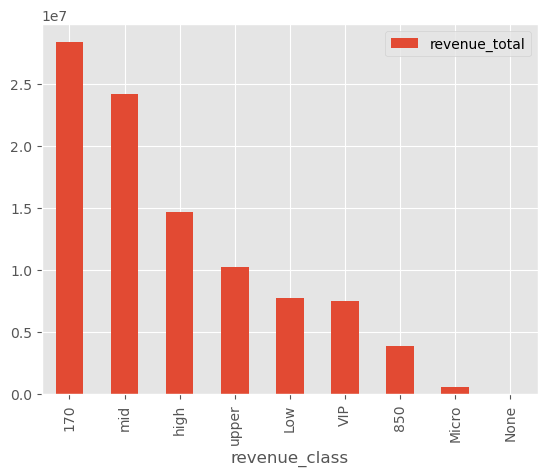

In [9]:
user_revenue = df.groupby(["pk_cid", "revenue_class"])["revenue_total"].min().reset_index()

revenue_per_class = user_revenue.groupby("revenue_class")["revenue_total"].sum().reset_index()
revenue_per_class.sort_values("revenue_total", ascending = False, inplace = True)
revenue_per_class.plot(kind = "bar", x = "revenue_class", y = "revenue_total")

## Thoughts SO FAR
- main income source are 170 (users with just active EM_ACCOUNT over 17 month)
- second main income comes from mid (170-849 revenue). Might be able to learn a lot from this group as it comes with a lot of data observations and a lot of variance in products and retention
- 850 may be worth a look as well, EM_ACCOUNT + DEBIT_CARD Over 17 month uninterrupted. ~4800 users

In [10]:
def check_rev_group(group):
    temp = df[df["revenue_class"] == group]
    print(temp.groupby("pk_cid")[products].mean().mean().sort_values(ascending = False) * 100)
    (temp.groupby("pk_cid")[products].mean().mean().sort_values(ascending = False) * 100).plot(kind = "bar")

em_acount            74.97
debit_card           33.33
emc_account          15.84
pension_plan          7.65
payroll_product       7.22
long_term_deposit     3.92
short_term_deposit    2.02
credit_card           1.72
securities            0.51
funds                 0.24
loans                 0.01
mortgage              0.00
em_account_p          0.00
dtype: float64


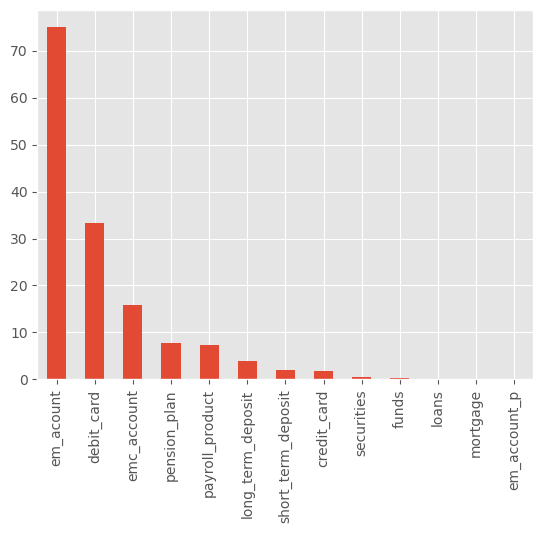

In [11]:
check_rev_group("mid")

### revenue segment generalization

In [12]:
revenue_classes = ["Micro", "Low", "170", "mid", "850", "upper", "high", "VIP"]

results_dict_ = {}
for rev_class in revenue_classes:
    rev_class_df = df[df["revenue_class"] == rev_class]
    avg_retention = rev_class_df.groupby("pk_cid")[products].sum().mean().sort_values(ascending = False)
    results_dict_[rev_class] = avg_retention
avg_retention = pd.DataFrame(results_dict_)

avg_retention.style.background_gradient(axis = None) ## Shows the average retention rate for each product for each revenue class

,Micro,Low,170,mid,850,upper,high,VIP
credit_card,0.002855,0.006664,0.000096,0.249044,0.165572,0.820208,2.339426,8.407662
debit_card,0.014612,0.088292,0.009196,4.631707,16.176303,7.114853,11.844315,14.358874
em_account_p,0.000000,0.000000,0.000000,0.000000,0.000000,0.001714,0.001807,0.000000
em_acount,2.567883,8.702438,16.701367,11.143292,16.346693,9.083997,5.298831,4.259332
emc_account,0.169731,0.270844,0.250725,2.475775,0.194919,4.410205,5.163549,10.031107
funds,0.000000,0.000447,0.000012,0.028360,0.013798,0.493597,0.673539,2.360183
loans,0.000000,0.000037,0.000000,0.000929,0.007446,0.003126,0.014028,0.071054
long_term_deposit,0.000000,0.001117,0.000018,0.477997,0.189225,3.991631,2.345271,3.865750
mortgage,0.000000,0.000025,0.000000,0.000692,0.000000,0.000504,0.005526,0.074329
payroll_product,0.000000,0.026916,0.001360,0.839933,0.221419,3.503176,8.898725,12.373281


In [13]:
results_dict = {}
for rev_class in revenue_classes:
    rev_class_df = df[df["revenue_class"] == rev_class]
    avg_had_product = (rev_class_df.groupby("pk_cid")[products].mean().mean() * 100).sort_values(ascending = False)
    results_dict[rev_class] = avg_had_product
avg_had_product = pd.DataFrame(results_dict)

avg_had_product.style.background_gradient(axis = None) ## Shows how many people in each revenue class had each product at least once on average (in %)

,Micro,Low,170,mid,850,upper,high,VIP
credit_card,0.049183,0.100123,0.001217,1.715226,0.976914,5.041332,13.954010,49.526763
debit_card,0.505882,1.751564,0.146082,33.326626,95.410078,43.669802,70.603151,84.660850
em_account_p,0.000000,0.000000,0.000000,0.000000,0.000000,0.010084,0.010627,0.000000
em_acount,60.636687,91.217329,98.443747,74.970434,96.513241,54.994733,31.581110,25.145085
emc_account,2.478101,2.271946,1.486472,15.841211,1.178228,26.464103,30.622461,59.116188
funds,0.000000,0.012032,0.000114,0.240838,0.101089,3.006470,4.052851,13.924377
loans,0.000000,0.001241,0.000000,0.005786,0.043802,0.018783,0.084072,0.417967
long_term_deposit,0.000000,0.014293,0.000127,3.923120,1.353098,24.355594,14.014253,22.856555
mortgage,0.000000,0.000620,0.000000,0.004085,0.000000,0.002966,0.032506,0.449705
payroll_product,0.000000,0.522138,0.017102,7.224081,1.619189,22.205999,53.127647,72.979123


In [14]:
def retention_vs_had_prod(product):
    product_avg = avg_had_product.loc[product]
    product_results = avg_retention.loc[product]

    fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
    sns.lineplot(x=product_avg.index, y=product_avg.values, ax=axs[0])
    axs[0].set_ylabel(f"Average % of people who had product")
    axs[0].set_title(f"{product}\nAverage % of people who had product")
    sns.lineplot(x=product_results.index, y=product_results.values, ax=axs[1])
    axs[1].set_ylabel(f"Average retention for {product} in months")
    axs[1].set_title(f"Retention by revenue class in months")
    fig.tight_layout(pad=2)
    plt.show()

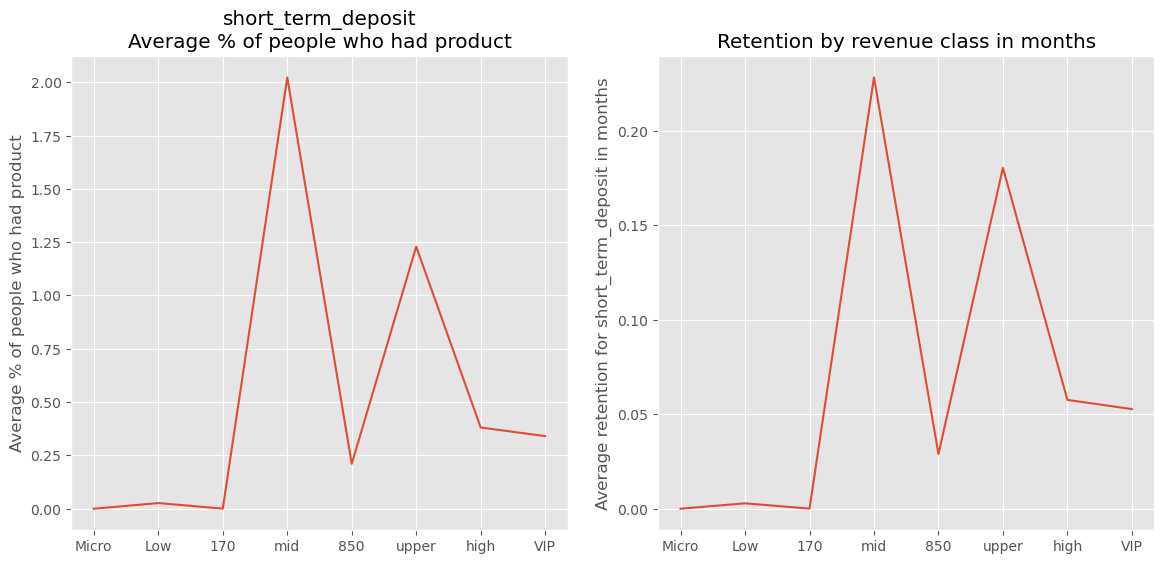

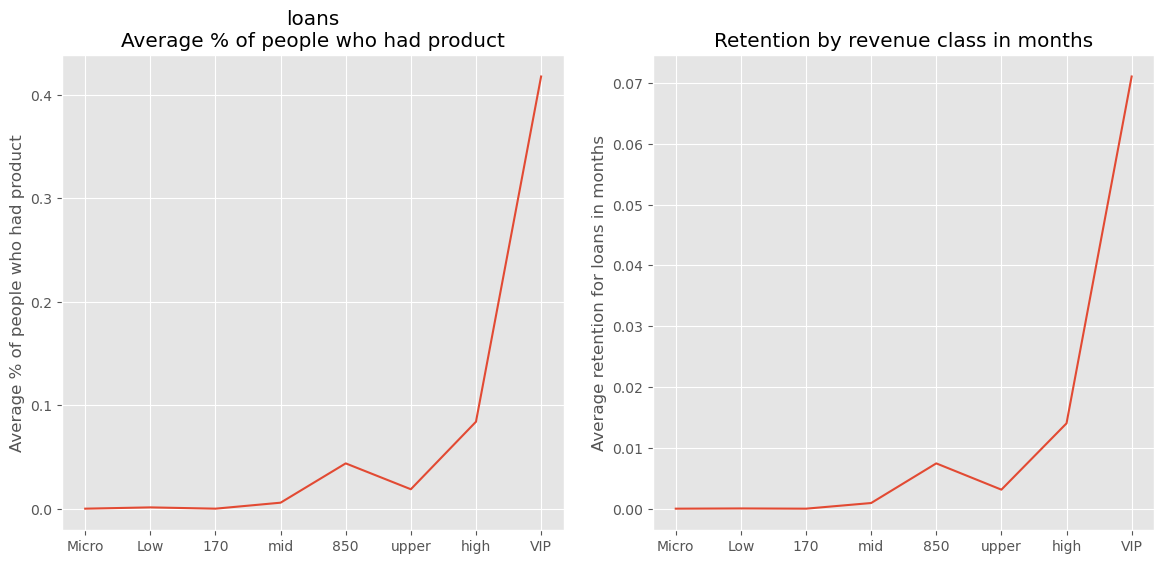

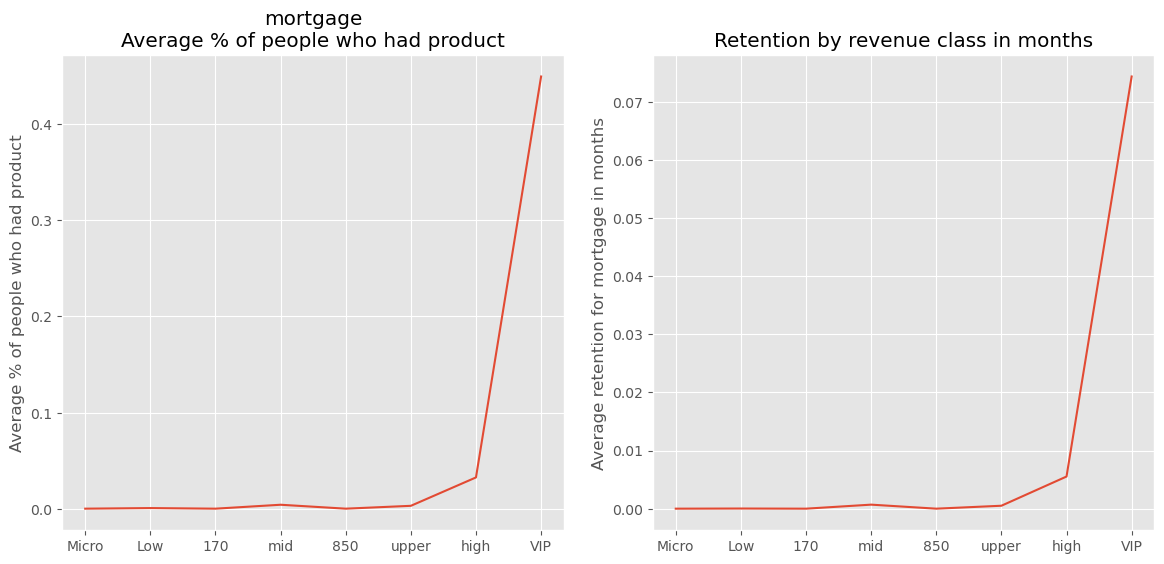

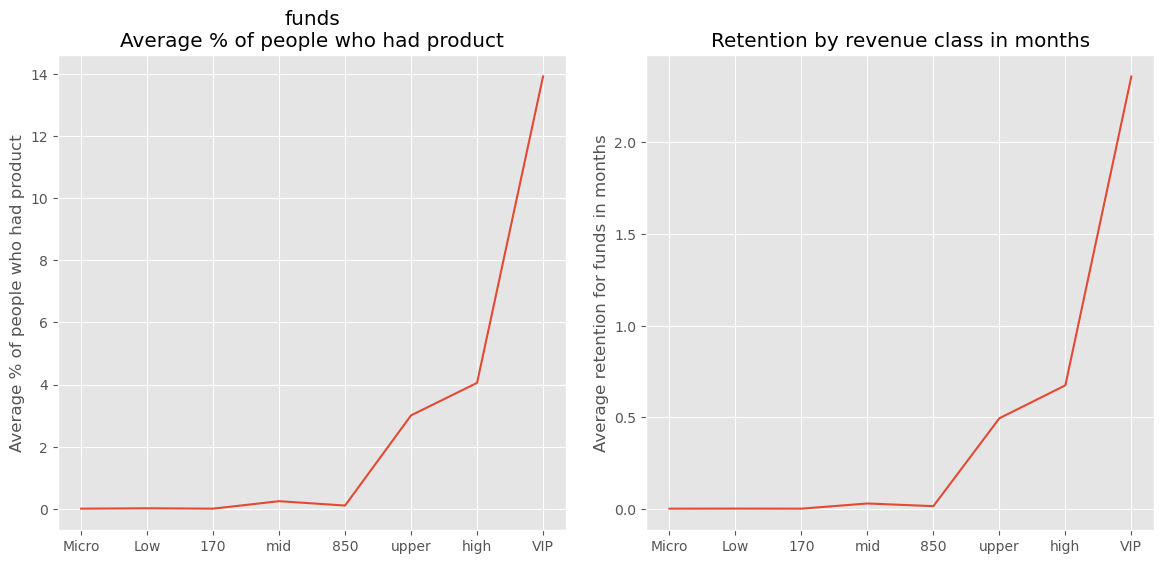

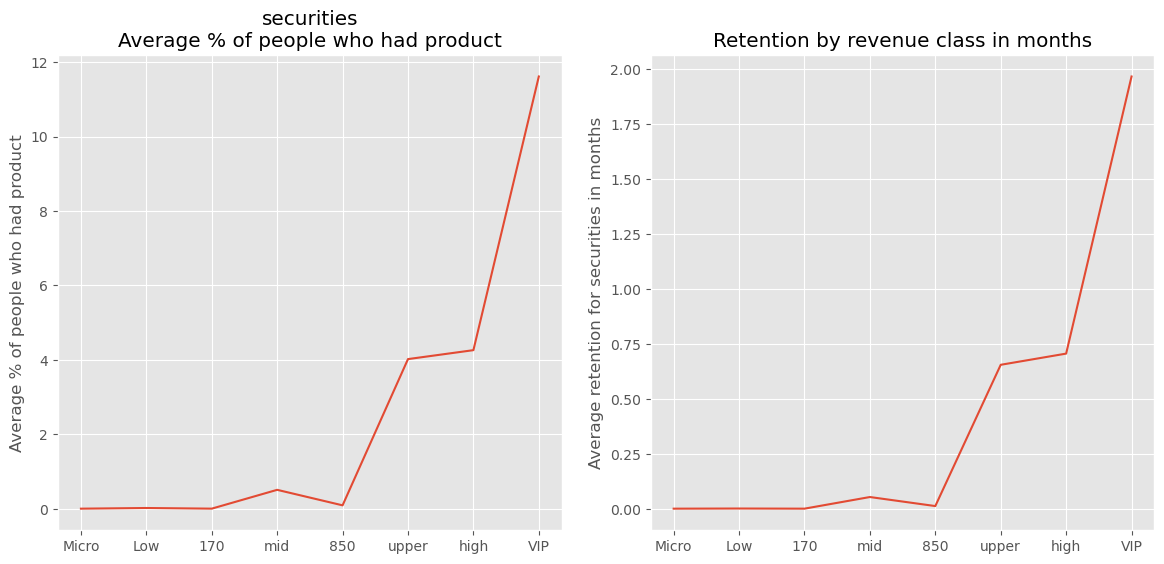

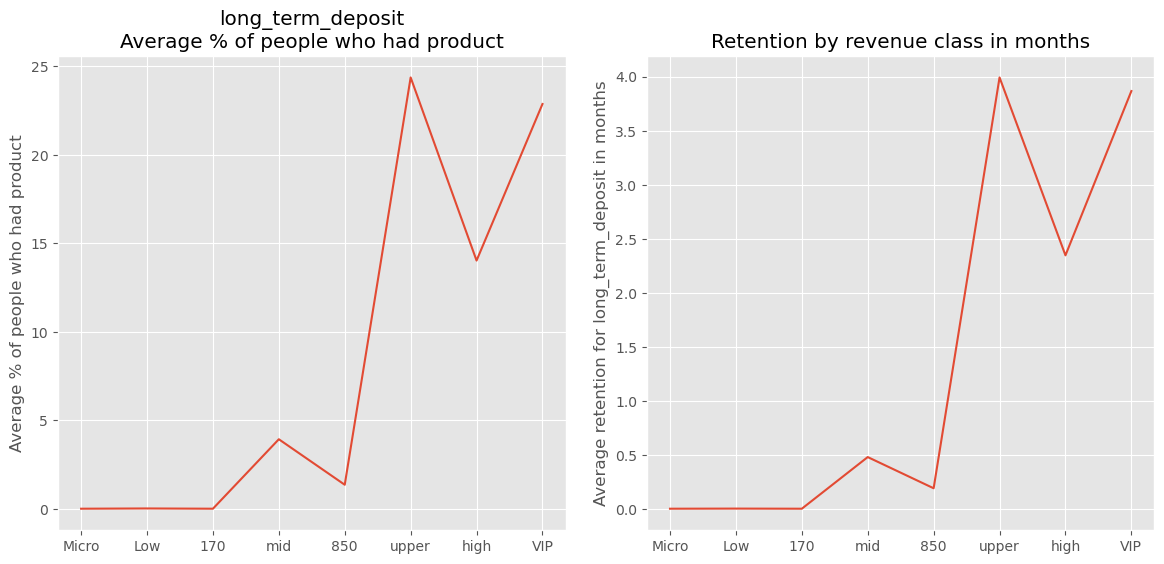

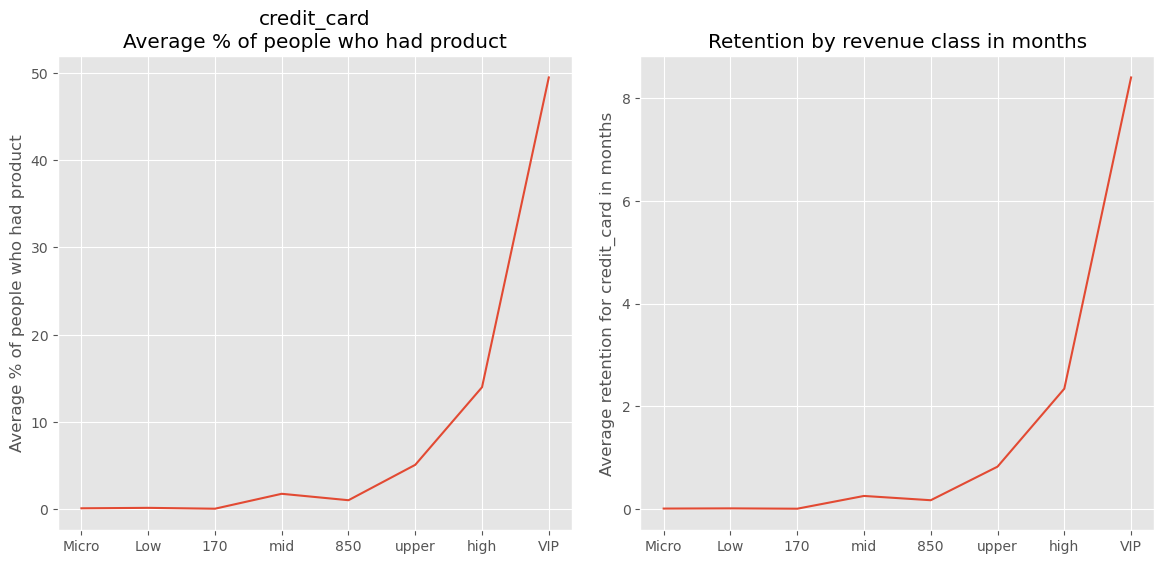

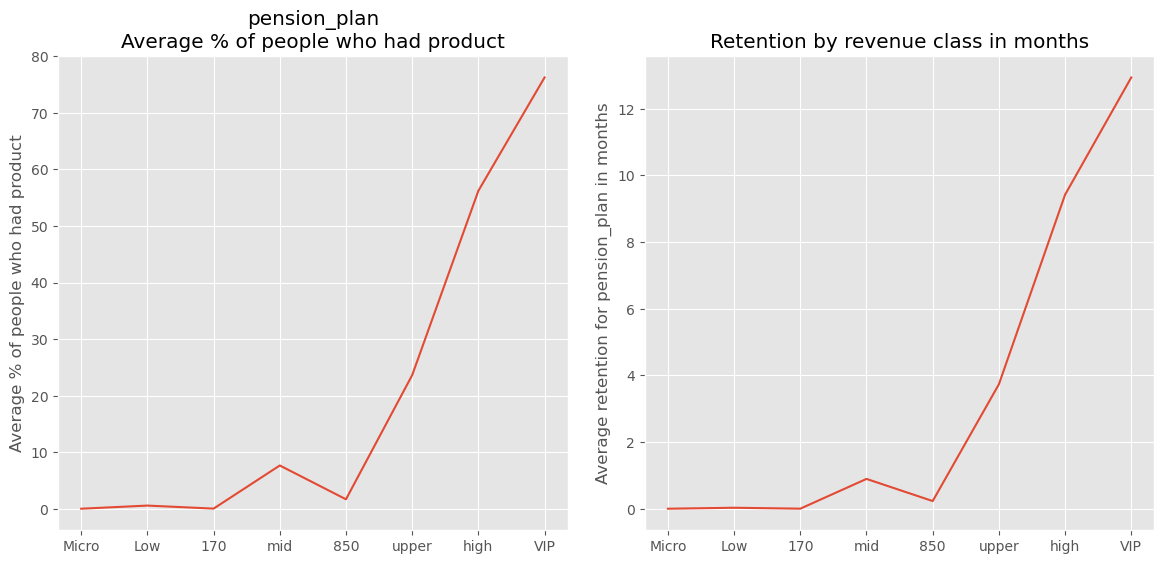

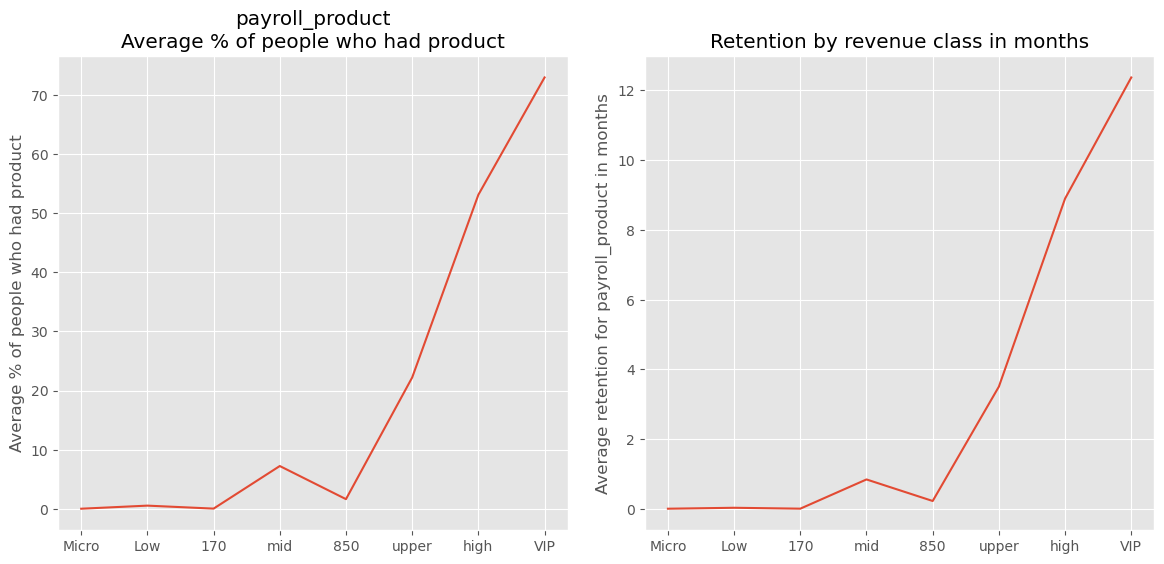

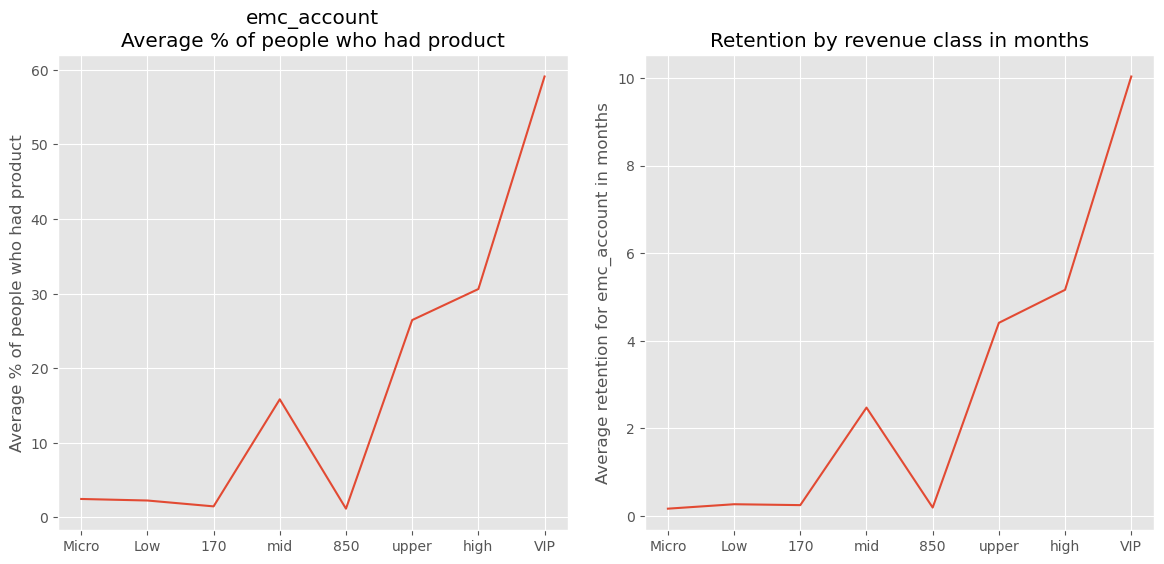

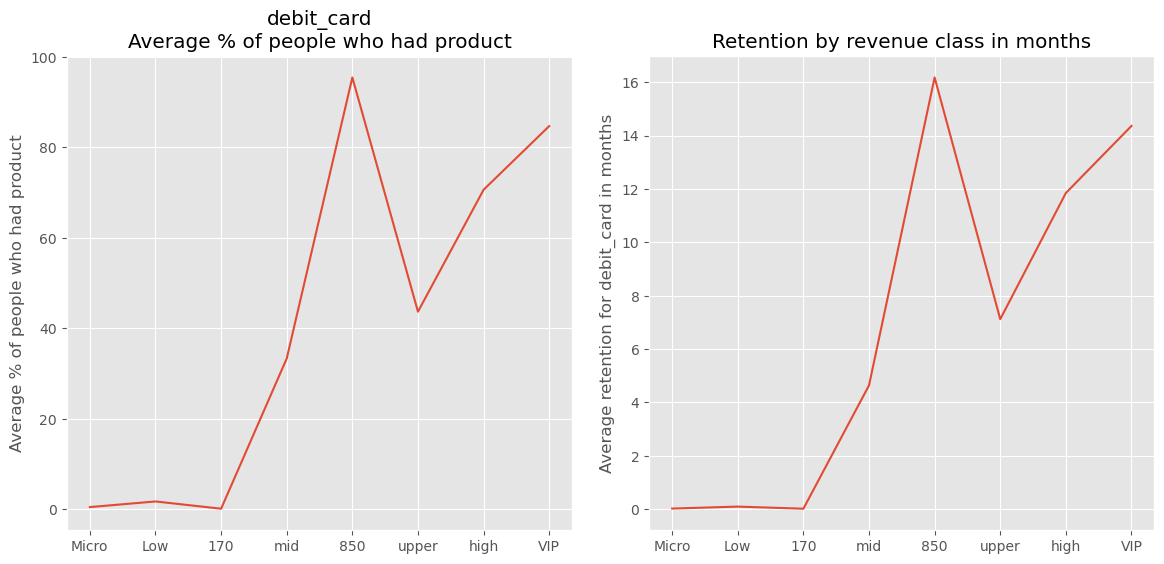

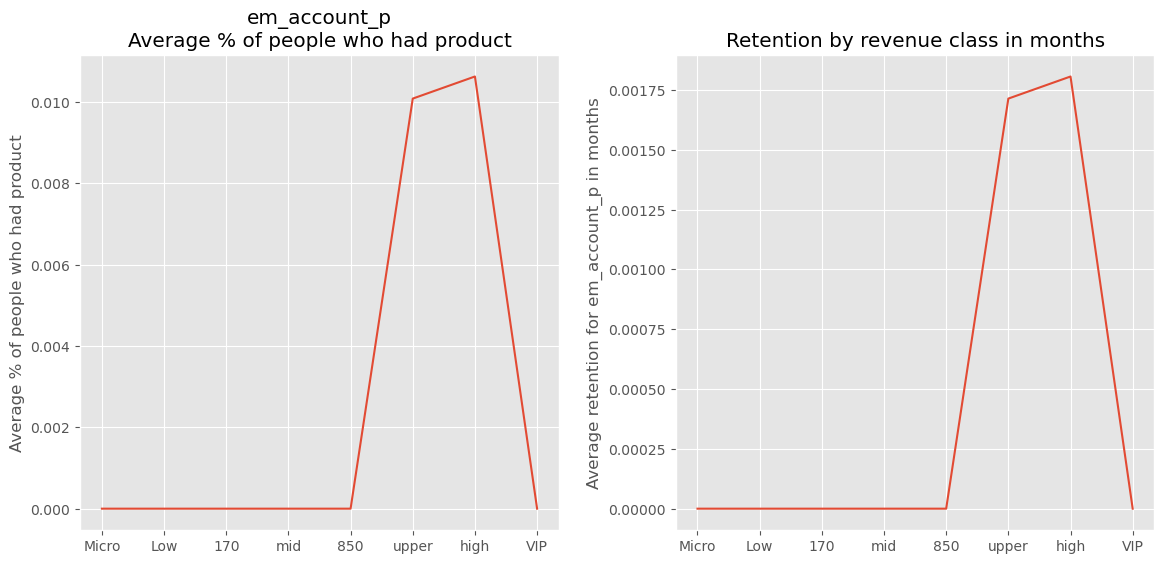

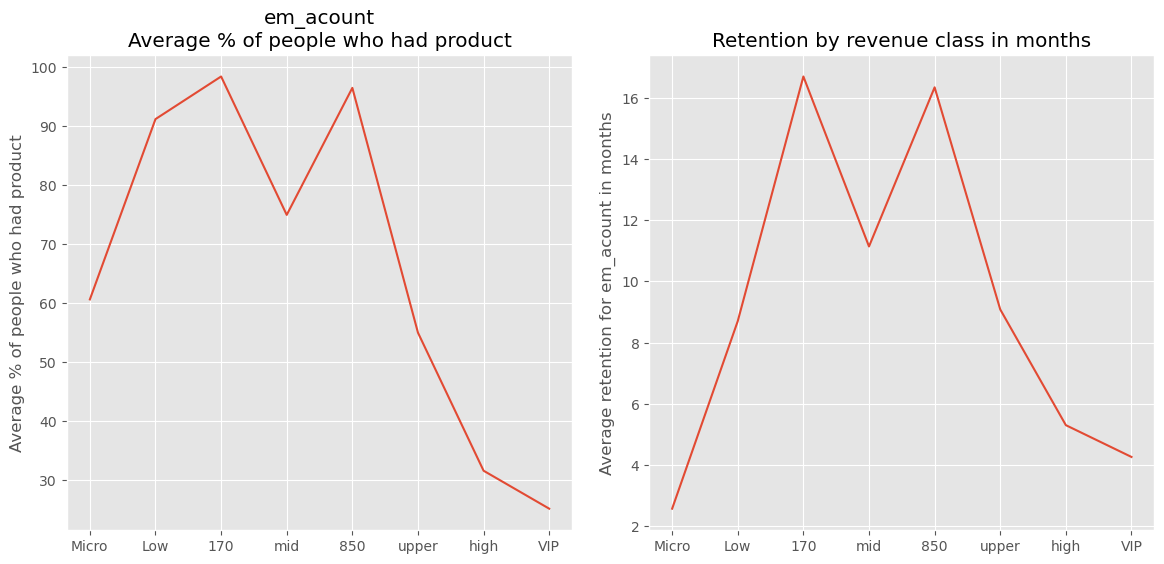

In [15]:
for prod in products:
    retention_vs_had_prod(prod)

In [16]:
best_prod = avg_had_product[["upper", "high", "VIP"]]
avg_had_product_best = best_prod[best_prod.gt(30).any(axis = 1)]
avg_had_product_best

,upper,high,VIP
credit_card,5.04,13.95,49.53
debit_card,43.67,70.60,84.66
em_acount,54.99,31.58,25.15
emc_account,26.46,30.62,59.12
payroll_product,22.21,53.13,72.98
pension_plan,23.62,56.23,76.27


In [17]:
best_prod_ = avg_retention[["upper", "high", "VIP"]]
avg_retention_best = best_prod_[best_prod_.gt(5).any(axis = 1)]
avg_retention_best

,upper,high,VIP
credit_card,0.82,2.34,8.41
debit_card,7.11,11.84,14.36
em_acount,9.08,5.30,4.26
emc_account,4.41,5.16,10.03
payroll_product,3.50,8.90,12.37
pension_plan,3.73,9.42,12.93


In [18]:
best_upper_plus_products = list(avg_retention_best.index)
best_upper_plus_products

['credit_card',
 'debit_card',
 'em_acount',
 'emc_account',
 'payroll_product',
 'pension_plan']

In [19]:
def cooccurrence_calculator(data, subset, sub_value, product_list, combinations):
    data = data[data[subset] == sub_value]
    data = data[product_list + ["pk_cid", "pk_partition"]]
    unique_customers = data["pk_cid"].unique()
    print(f"Number of unique customers: {len(unique_customers)}")
    cooccurrence_dict = {}
    for pair in itertools.combinations(product_list, combinations):
        cooccurrence_dict[pair] = {"count": 0, "cooccurrence": 0}

    for cid in unique_customers:
        customer_df = data[data["pk_cid"] == cid]
        customer_prod_df = customer_df.groupby("pk_partition")[product_list].sum()
        for pair in itertools.combinations(product_list, combinations):
            pair_count = (customer_prod_df[list(pair)].sum(axis = 1) == len(pair)).sum()
            cooccurrence_dict[pair]["count"] += (pair_count > 0)
            cooccurrence_dict[pair]["cooccurrence"] += pair_count
        
    cooccurrence_means = {k: v["count"] / len(unique_customers) if v["count"] > 0 else 0 for k, v in cooccurrence_dict.items()}
    cooccurrence_counts = {k: v["count"] for k, v in cooccurrence_dict.items()}
    
    cooccurrence_df = pd.DataFrame.from_dict(cooccurrence_means, orient = "index", columns = ["mean_cooccurrence"])
    cooccurrence_df["user_count"] = pd.Series(cooccurrence_counts)
    cooccurrence_df.index.name = "product_pairs"
    cooccurrence_df.sort_values("mean_cooccurrence", ascending = False, inplace = True)
    
    return cooccurrence_df

In [20]:
madridians = df[df["region"] == "Madrid"]
cooc_vip_madrid = cooccurrence_calculator(
    madridians, "revenue_class", "VIP", best_upper_plus_products, 5)
cooc_vip_madrid.head(10)

Number of unique customers: 1344


,mean_cooccurrence,user_count
product_pairs,,
"(credit_card, debit_card, emc_account, payroll_product, pension_plan)",0.38,510
"(debit_card, em_acount, emc_account, payroll_product, pension_plan)",0.10,133
"(credit_card, debit_card, em_acount, payroll_product, pension_plan)",0.09,117
"(credit_card, em_acount, emc_account, payroll_product, pension_plan)",0.06,81
"(credit_card, debit_card, em_acount, emc_account, pension_plan)",0.06,78
"(credit_card, debit_card, em_acount, emc_account, payroll_product)",0.06,77


In [21]:
## VIPS 5
cooc_vip_barce = cooccurrence_calculator(
    df, "revenue_class", "VIP", best_upper_plus_products, 5)
cooc_vip_barce.head(10)

Number of unique customers: 3054


,mean_cooccurrence,user_count
product_pairs,,
"(credit_card, debit_card, emc_account, payroll_product, pension_plan)",0.36,1104
"(debit_card, em_acount, emc_account, payroll_product, pension_plan)",0.09,273
"(credit_card, debit_card, em_acount, payroll_product, pension_plan)",0.08,249
"(credit_card, em_acount, emc_account, payroll_product, pension_plan)",0.05,166
"(credit_card, debit_card, em_acount, emc_account, pension_plan)",0.05,160
"(credit_card, debit_card, em_acount, emc_account, payroll_product)",0.05,159


In [22]:
## VIPS 4
cooc_vip_barce = cooccurrence_calculator(
    df, "revenue_class", "VIP", best_upper_plus_products, 4)
cooc_vip_barce.head(10)

Number of unique customers: 3054


,mean_cooccurrence,user_count
product_pairs,,
"(credit_card, debit_card, payroll_product, pension_plan)",0.61,1853
"(debit_card, emc_account, payroll_product, pension_plan)",0.50,1531
"(credit_card, debit_card, emc_account, pension_plan)",0.38,1146
"(credit_card, emc_account, payroll_product, pension_plan)",0.37,1131
"(credit_card, debit_card, emc_account, payroll_product)",0.36,1104
"(debit_card, em_acount, payroll_product, pension_plan)",0.14,427
"(em_acount, emc_account, payroll_product, pension_plan)",0.09,288
"(debit_card, em_acount, emc_account, pension_plan)",0.09,276
"(debit_card, em_acount, emc_account, payroll_product)",0.09,273


In [23]:
## HIGH 5
cooc_high_barce = cooccurrence_calculator(
    df, "revenue_class", "high", best_upper_plus_products, 5)
cooc_high_barce.head(10)

Number of unique customers: 9410


,mean_cooccurrence,user_count
product_pairs,,
"(credit_card, debit_card, emc_account, payroll_product, pension_plan)",0.04,353
"(debit_card, em_acount, emc_account, payroll_product, pension_plan)",0.03,275
"(credit_card, debit_card, em_acount, payroll_product, pension_plan)",0.01,112
"(credit_card, em_acount, emc_account, payroll_product, pension_plan)",0.01,49
"(credit_card, debit_card, em_acount, emc_account, pension_plan)",0.00,43
"(credit_card, debit_card, em_acount, emc_account, payroll_product)",0.00,42


In [24]:
## HIGH 4
cooc_high_barce = cooccurrence_calculator(
    df, "revenue_class", "high", best_upper_plus_products, 4)
cooc_high_barce.head(10)

Number of unique customers: 9410


,mean_cooccurrence,user_count
product_pairs,,
"(debit_card, emc_account, payroll_product, pension_plan)",0.17,1580
"(credit_card, debit_card, payroll_product, pension_plan)",0.13,1191
"(debit_card, em_acount, payroll_product, pension_plan)",0.10,957
"(credit_card, emc_account, payroll_product, pension_plan)",0.05,435
"(credit_card, debit_card, emc_account, pension_plan)",0.04,372
"(credit_card, debit_card, em_acount, emc_account)",0.04,360
"(credit_card, debit_card, emc_account, payroll_product)",0.04,353
"(em_acount, emc_account, payroll_product, pension_plan)",0.04,332
"(debit_card, em_acount, emc_account, pension_plan)",0.03,287


In [25]:
## HIGH 3
cooc_high_barce = cooccurrence_calculator(
    df, "revenue_class", "high", best_upper_plus_products, 3)
cooc_high_barce.head(10)

Number of unique customers: 9410


,mean_cooccurrence,user_count
product_pairs,,
"(debit_card, payroll_product, pension_plan)",0.68,6401
"(emc_account, payroll_product, pension_plan)",0.19,1794
"(debit_card, emc_account, pension_plan)",0.18,1686
"(debit_card, emc_account, payroll_product)",0.17,1580
"(credit_card, payroll_product, pension_plan)",0.14,1363
"(credit_card, debit_card, pension_plan)",0.13,1260
"(em_acount, payroll_product, pension_plan)",0.13,1252
"(credit_card, debit_card, payroll_product)",0.13,1191
"(debit_card, em_acount, pension_plan)",0.11,992


## CONCLUSION:

Customers with high + retention and high + revenue majorly have debit_card, payroll_account and pension_plan.  
The next missing product in order to get to VIP level is a credit_card.

→ find customers that have no credit card yet, but active debit_card, payroll_account and pension_plan throughout 3 most recent months.
→ take the top 10000k

In [28]:
df_last_3m = df[df["pk_partition"] > "2019-03-01"]
df_last_3m["pk_cid"].nunique()

445397

In [30]:
output = df_last_3m.groupby("pk_cid")["debit_card", "payroll_product", "pension_plan", "credit_card"].sum()

# filter the rows based on the conditions
filtered_output = output[(output["credit_card"] == 0) & 
                         (((output["debit_card"] > 2) & (output["pension_plan"] > 2)) |
                          ((output["debit_card"] > 2) & (output["payroll_product"] > 2)) |
                          ((output["payroll_product"] > 2) & (output["pension_plan"] > 2)))]

filtered_output["highest_retention"] = filtered_output.sum(axis = 1)
filtered_output.sort_values("highest_retention", ascending = False, inplace = True)

In [31]:
best_10000_for_credit_card = filtered_output.head(10000)
best_10000_for_credit_card

,debit_card,payroll_product,pension_plan,credit_card,highest_retention
pk_cid,,,,,
997088,3,3,3,0,9
1239742,3,3,3,0,9
1397355,3,3,3,0,9
1240294,3,3,3,0,9
1240289,3,3,3,0,9
...,...,...,...,...,...
1246361,0,3,3,0,6
1394764,0,3,3,0,6
1246339,0,3,3,0,6


In [32]:
best_1000_full = df[df["pk_cid"].isin(best_10000_for_credit_card.index)]
best_1000_full.to_csv("../data/manual_best_1000_full.csv", index = False)